### Initialize and define functions

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define a function to calculate the compressor control voltage (vdc) based on fan speed and power
def compressor_vdc(fan_speed, power, power_low):
    # Initialize the vdc Series with zeros and the same length as fan_speed
    vdc = pd.Series(0, index=fan_speed.index)
    
    # Conditions for calculating vdc
    condition = (fan_speed >= 49) & (power > power_low)
    vdc[condition] = (fan_speed[condition] / 100 + 0.0179) / 0.2073
    
    # Apply maximum limit for vdc
    vdc[vdc > 4.91] = 4.91
    
    # Ensure vdc does not go below 0 (assuming this was meant to apply to vdc, not p, based on context)
    vdc[vdc < 0] = 0
    
    return vdc

# Define a function to calculate the compressor speed ratio based on vdc
def comp_spd_ratio(vdc):
    # Comp Speed Ratio Coefficients (vdc >= 2.42)
    m1 = (1 - 0.317) / (4.91 - 2.42)
    b1 = 0.317 - 2.42 * m1
    # Comp Speed Ratio Coefficients (vdc < 2.42)
    m2 = 0.317 / 2.42
    
    # Initialize y with zeros
    y = pd.Series(0, index=vdc.index)
    
    # Conditions for selecting coefficients
    cond = vdc >= 2.42
    m = pd.Series(m2, index=vdc.index)  # Default to m2
    b = pd.Series(0, index=vdc.index)   # Default to 0
    
    # Update m and b based on condition
    m[cond] = m1
    b[cond] = b1
    
    # Calculate compressor speed ratio
    y = m * vdc + b
    
    return y

# Define a function to calculate accumulated error 
def accumulated_errors(pv, spt, criteria_series, reset_threshold):
    """
    Calculate accumulated errors based on a process variable (pv),
    setpoint (spt), and a criteria series that determines when to reset
    the accumulated error based on the reset threshold.

    Parameters:
    - pv: Pandas Series representing the process variable or temperature.
    - spt: Pandas Series representing the setpoint.
    - criteria_series: Pandas Series representing the criteria for resetting accumulation.
    - reset_threshold: Scalar value that defines the threshold for resetting.

    Returns:
    - Pandas Series representing the accumulated error.
    """
    # Initialize the accumulated error series with the same index as the input series
    acc_errors = pd.Series(0, index=pv.index)
    
    # Initialize a variable to keep track of the current accumulated error
    current_acc_error = 0
    
    # Determine system off state using rolling window
    system_off = criteria_series.rolling(window=15*12, min_periods=1).max() < reset_threshold

    # Iterate through the series by index
    for i in pv.index:
        if system_off[i]:
            # Reset accumulated error to 0 if power is below the threshold
            current_acc_error = 0
        else:
            # Calculate the error as the difference between temperature and setpoint
            error = pv[i] - spt[i]
            # Check if adding the error exceeds the max accumulation limit
            if current_acc_error + error > 4000:
                # Here, we set the accumulated error to 3000 if adding the next error would exceed it
                current_acc_error = 4000
            else:
                current_acc_error += error  # Accumulate the error within limit
        
        # Assign the current accumulated error to the series
        acc_errors[i] = current_acc_error
    
    return acc_errors


### Load data files

In [6]:
# Specify the data folder path
data_folder = 'data/'

# Get a list of all files in the data folder
files = os.listdir(data_folder)

# Print the list of files
print("Available data files:")
for i, file in enumerate(files):
    print(f"{i+1}. {file}")

# Specify the number of the file to load
file_number = 6  # Change this number to load a different file

# Check if the specified file number is valid
if file_number < 1 or file_number > len(files):
    print("Invalid file number. Please choose a valid file number.")
else:
    # Get the file path of the selected file
    file_path = os.path.join(data_folder, files[file_number-1])

Available data files:
1. Test_AtlantaSHiftExtSum_07162023_0005.csv
2. Test_Atlanta_Default_random2_102623_2106.csv
3. Test_TusconShiftSTD2019_041123_2101.csv
4. Test_AtlantaTES_04222023_2302.csv
5. Test_NewYorkShiftSTD2019_05312023_2327.csv
6. Test_AtlantaShiftSTD2019_04092023_2320.csv
7. Test_BuffaloShiftSTD2019_060723_1026.csv
8. Test_TucsonShiftSaveBehav_03282023_2135.csv
9. Test_NewYorkShiftDef_03312023_1837.csv
10. Test_TucsonShiftDef_032523_1125.csv
11. Test_Atlanta_Default_1hr_110123_1357.csv
12. Test_Atlanta_Default_Random_102923_1331.csv
13. Test_Atlanta_Default_MPC_Pretest_122723_1025.csv
14. Test_Atlanta_Default_random_102423_1727.csv
15. Test_BuffaloShiftSaveBehave_06182023_0242.csv
16. Test_AtlantaShiftDefault_061623_1055.csv
17. Test_BuffaloShiftDef_06022023_1805.csv
18. Test_BuffaloShiftExtSum_060323_2005.csv
19. Test_NewYorkShiftDenseOcc_04012023_2115.csv
20. Test_BuffaloShiftDenseOcc_06142023_2109.csv


### Feature analysis

i: 0, file: Test_AtlantaSHiftExtSum_07162023_0005.csv
Correlation acc_errors: 0.8934
Correlation errors: 0.0081
Correlation errors: -0.1136
Correlation wshp_power: 0.9149


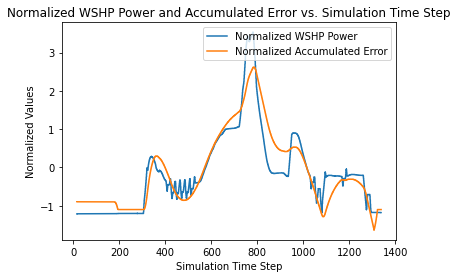

i: 1, file: Test_Atlanta_Default_random2_102623_2106.csv
Correlation acc_errors: 0.5956
Correlation errors: 0.7065
Correlation errors: 0.2667
Correlation wshp_power: 0.6020


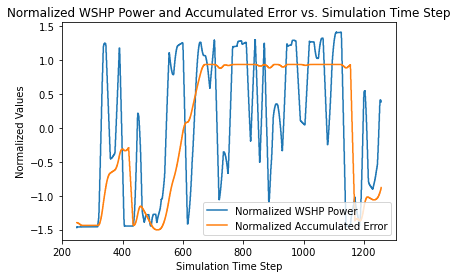

i: 2, file: Test_TusconShiftSTD2019_041123_2101.csv
Correlation acc_errors: 0.9664
Correlation errors: -0.0406
Correlation errors: -0.0640
Correlation wshp_power: 0.9727


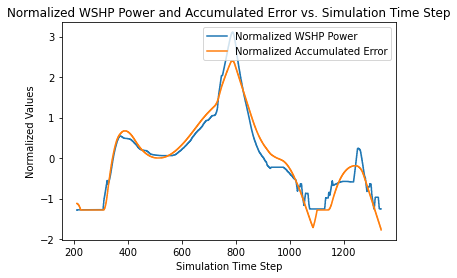

i: 3, file: Test_AtlantaTES_04222023_2302.csv
Correlation acc_errors: 0.9001
Correlation errors: -0.1720
Correlation errors: -0.3678
Correlation wshp_power: 0.8628


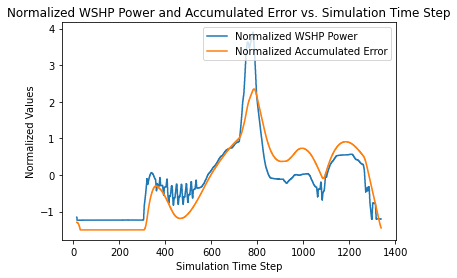

i: 4, file: Test_NewYorkShiftSTD2019_05312023_2327.csv
Correlation acc_errors: 0.8311
Correlation errors: 0.0835
Correlation errors: 0.2038
Correlation wshp_power: 0.7472


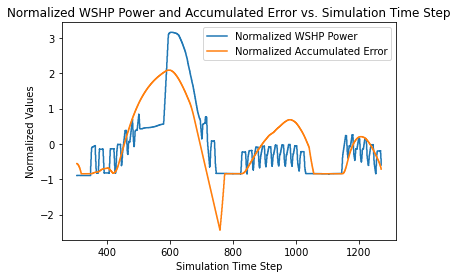

i: 5, file: Test_AtlantaShiftSTD2019_04092023_2320.csv
Correlation acc_errors: 0.7857
Correlation errors: 0.0398
Correlation errors: -0.3292
Correlation wshp_power: 0.7531


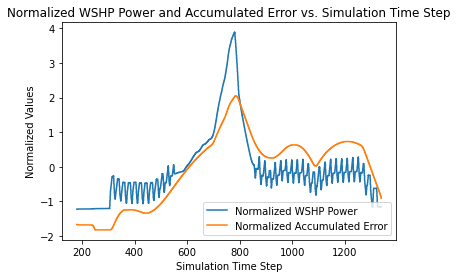

i: 6, file: Test_BuffaloShiftSTD2019_060723_1026.csv
Correlation acc_errors: 0.6232
Correlation errors: 0.0819
Correlation errors: 0.2017
Correlation wshp_power: 0.5438


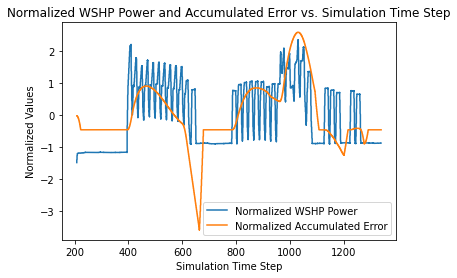

i: 7, file: Test_TucsonShiftSaveBehav_03282023_2135.csv
Correlation acc_errors: 0.8505
Correlation errors: 0.1312
Correlation errors: -0.1605
Correlation wshp_power: 0.8652


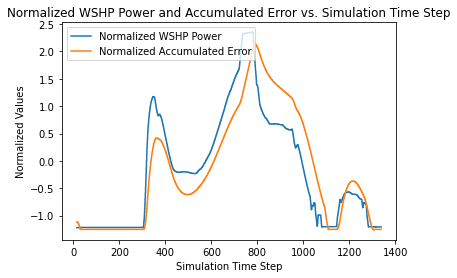

i: 8, file: Test_NewYorkShiftDef_03312023_1837.csv
Correlation acc_errors: 0.8746
Correlation errors: 0.1972
Correlation errors: -0.1099
Correlation wshp_power: 0.7957


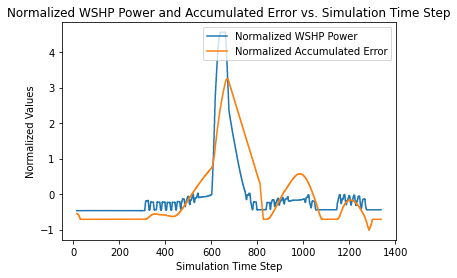

i: 9, file: Test_TucsonShiftDef_032523_1125.csv
Correlation acc_errors: 0.7292
Correlation errors: -0.1149
Correlation errors: -0.0741
Correlation wshp_power: 0.7356


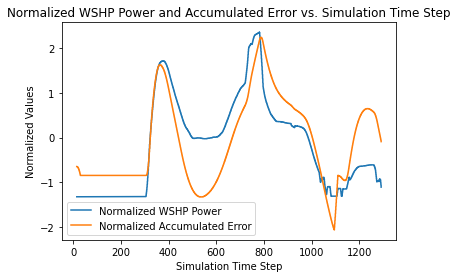

i: 10, file: Test_Atlanta_Default_1hr_110123_1357.csv
Correlation acc_errors: 0.6503
Correlation errors: 0.5412
Correlation errors: 0.0591
Correlation wshp_power: 0.5950


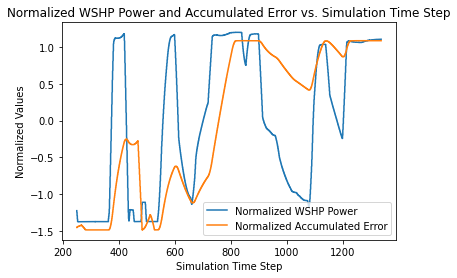

i: 11, file: Test_Atlanta_Default_Random_102923_1331.csv
Correlation acc_errors: 0.4684
Correlation errors: 0.5544
Correlation errors: -0.0512
Correlation wshp_power: 0.3961


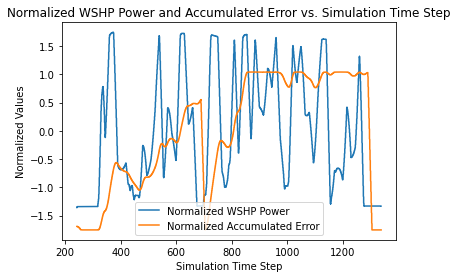

i: 12, file: Test_Atlanta_Default_MPC_Pretest_122723_1025.csv
Correlation acc_errors: 0.9593
Correlation errors: -0.4650
Correlation errors: -0.5036
Correlation wshp_power: 0.9378


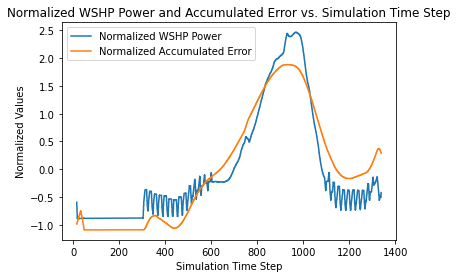

i: 13, file: Test_Atlanta_Default_random_102423_1727.csv
Correlation acc_errors: 0.4879
Correlation errors: 0.7123
Correlation errors: 0.1495
Correlation wshp_power: 0.4081


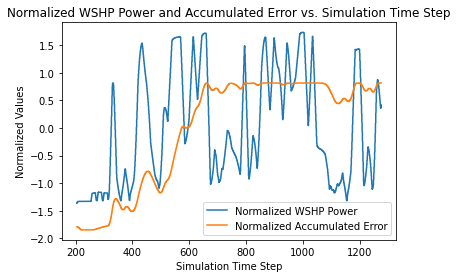

i: 14, file: Test_BuffaloShiftSaveBehave_06182023_0242.csv
Correlation acc_errors: 0.7962
Correlation errors: 0.0484
Correlation errors: -0.1855
Correlation wshp_power: 0.8057


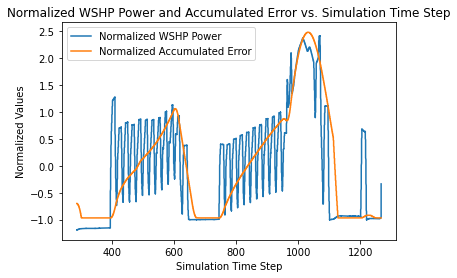

i: 15, file: Test_AtlantaShiftDefault_061623_1055.csv
Correlation acc_errors: 0.9227
Correlation errors: -0.1476
Correlation errors: -0.0936
Correlation wshp_power: 0.8743


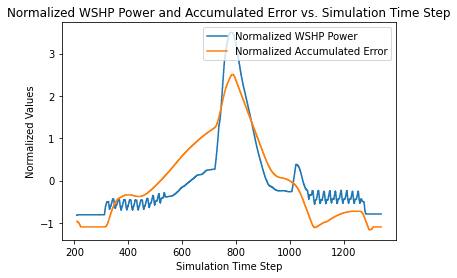

i: 16, file: Test_BuffaloShiftDef_06022023_1805.csv
Correlation acc_errors: 0.8365
Correlation errors: 0.1518
Correlation errors: -0.0303
Correlation wshp_power: 0.7939


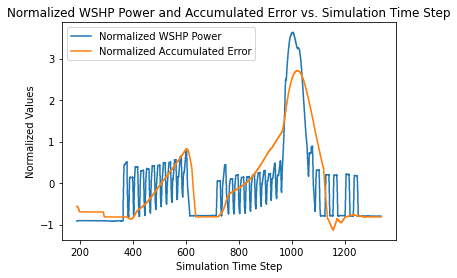

i: 17, file: Test_BuffaloShiftExtSum_060323_2005.csv
Correlation acc_errors: 0.8202
Correlation errors: 0.0811
Correlation errors: 0.0451
Correlation wshp_power: 0.6536


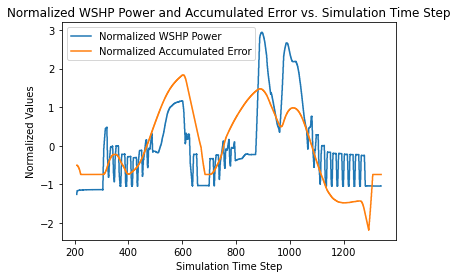

i: 18, file: Test_NewYorkShiftDenseOcc_04012023_2115.csv
Correlation acc_errors: 0.7727
Correlation errors: 0.2339
Correlation errors: -0.1965
Correlation wshp_power: 0.6307


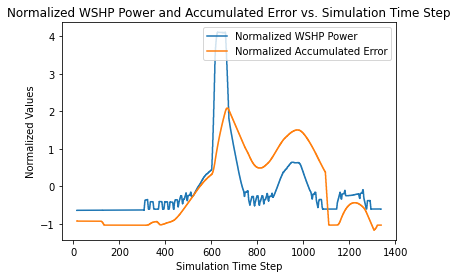

i: 19, file: Test_BuffaloShiftDenseOcc_06142023_2109.csv
Correlation acc_errors: 0.9224
Correlation errors: 0.1906
Correlation errors: -0.0297
Correlation wshp_power: 0.8401


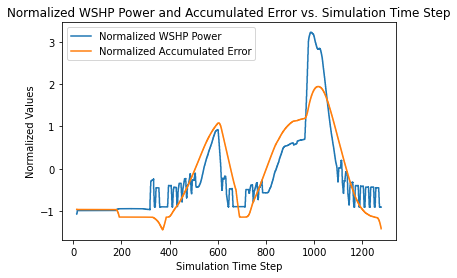

In [7]:
# Initialize empty pandas series to store the results of all iterations
comp_spd_avg_all_iterations = pd.Series(dtype='float')
acc_errors_avg_all_iterations = pd.Series(dtype='float')
errors_avg_all_iterations = pd.Series(dtype='float')
wshp_power_avg_all_iterations = pd.Series(dtype='float')

# Initialize a dictionary to store the results of each iteration
results = {}

# Loop through the file paths
for i, file in enumerate(files):

    # Get the file path of the selected file
    file_path = os.path.join(data_folder, file)
    print(f"i: {i}, file: {file}")

    # Read the csv file
    data = pd.read_csv(file_path)

    # Remove rows where 'Simulation Time Step' is <= 0 and >=1339
    data = data[data['Simulation Time Step'] > 0]
    data = data[data['Simulation Time Step'] < 1339]
    data = data.reset_index(drop=True)

    # Extract column 'Current Simulation Step'
    simulation_time_step = data['Simulation Time Step']
    # Extract column that contains 'Sim Zone Temp'
    sim_zone_temp = data.filter(like='Sim Zone Temp').iloc[:, 0]
    # Extract column that contains 'Active Setpoint'
    active_setpoint = data.filter(like='Active Setpoint').iloc[:, 0]
    # Extract column that contains 'Fan Speed'
    fan_speed = data.filter(like='Fan Speed').iloc[:, 0]
    # Extract column that contains 'WSHP Power'
    wshp_power = data.filter(like='WSHP Power').iloc[:, 0]
    # Check if 'CompSpd' column exists
    if 'CompSpd' in data.columns:
        # Extract column 'CompSpd'
        vdc_recorded = data['CompSpd']
    else:
        vdc_recorded = None

    # Calculate the error between 'Sim Zone Temp' and 'Active Setpoint'
    errors = sim_zone_temp - active_setpoint

    # Calculate vdc based on fan speed and power
    vdc = compressor_vdc(fan_speed, wshp_power, 150)

    # Calculate the RMSE between vdc and vdc_recorded
    if vdc_recorded is not None:
        rmse = ((vdc - vdc_recorded) ** 2).mean() ** 0.5
        # print(f"RMSE between vdc and vdc_recorded: {rmse:.4f}")

    # Calculatre the compressor speed ratio based on vdc
    comp_spd = comp_spd_ratio(vdc)

    # Calculate min_avg minutes moving average of wshp_power
    min_avg = 15
    wshp_power_avg = wshp_power.rolling(min_avg*12).mean()

    # Calculate the accumulated errors
    criteria_series = wshp_power_avg
    reset_threshold = 150
    acc_errors = accumulated_errors(sim_zone_temp, active_setpoint, criteria_series, reset_threshold)

    # Calculate min_avg minutes moving average of other data
    comp_spd_avg = comp_spd.rolling(min_avg*12).mean()
    acc_errors_avg = acc_errors.rolling(min_avg*12).mean()
    errors_avg = errors.rolling(min_avg*12).mean()

    # Store the results of each iteration in a dictionary
    results[i] = {'comp_spd_avg': comp_spd_avg, 'acc_errors_avg': acc_errors_avg, 'errors_avg': errors_avg, 'wshp_power_avg': wshp_power_avg, 'simulation_time_step': simulation_time_step}

    # Concatenate the results of each iteration to the main Series
    comp_spd_avg_all_iterations = pd.concat([comp_spd_avg_all_iterations, comp_spd_avg], ignore_index=True)
    acc_errors_avg_all_iterations = pd.concat([acc_errors_avg_all_iterations, acc_errors_avg], ignore_index=True)
    errors_avg_all_iterations = pd.concat([errors_avg_all_iterations, errors_avg], ignore_index=True)
    wshp_power_avg_all_iterations = pd.concat([wshp_power_avg_all_iterations, wshp_power_avg], ignore_index=True)

    # # Take only the positive part of the accumulated errors
    # acc_errors_avg_pos = acc_errors_avg.copy()
    # acc_errors_avg_pos[acc_errors_avg_pos < 0] = 0

    # Calculate the correlation between the compressor speed ratio and the accumulated errors
    corr = comp_spd_avg.corr(acc_errors_avg)
    print(f"Correlation acc_errors: {corr:.4f}")
    corr = comp_spd_avg.corr(errors_avg)
    print(f"Correlation errors: {corr:.4f}")
    corr = errors_avg.corr(acc_errors_avg)
    print(f"Correlation errors: {corr:.4f}")
    corr = wshp_power_avg.corr(acc_errors_avg)
    print(f"Correlation wshp_power: {corr:.4f}")

    # Switch to make plots for each file
    if i == 0:

        # # Plot the temperature and setpoint
        # plt.figure()
        # plt.plot(simulation_time_step, sim_zone_temp, label='Sim Zone Temp')
        # plt.plot(simulation_time_step, active_setpoint, label='Active Setpoint')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Temperature')
        # plt.title('Temperature vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Plot the accumulated errors
        # plt.figure()
        # plt.plot(simulation_time_step, acc_errors)
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Accumulated Error')
        # plt.title('Accumulated Error vs. Simulation Time Step')
        # plt.show()

        # # Make a plot to compare vdc and vdc_recorded
        # if vdc_recorded is not None:
        #     plt.figure()
        #     plt.plot(simulation_time_step, vdc, label='vdc')
        #     plt.plot(simulation_time_step, vdc_recorded, label='vdc_recorded')
        #     plt.xlabel('Simulation Time Step')
        #     plt.ylabel('Compressor Control Voltage (Vdc)')
        #     plt.title('Compressor Control Voltage vs. Simulation Time Step')
        #     plt.legend()
        #     plt.show()

        # # Plot the compressor speed ratio
        # plt.figure()
        # plt.plot(simulation_time_step, comp_spd)
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Compressor Speed Ratio')
        # plt.title('Compressor Speed Ratio vs. Simulation Time Step')
        # plt.show()

        # # Plot the compressor speed ratio and its moving average
        # plt.figure()
        # plt.plot(simulation_time_step, comp_spd, label='Compressor Speed Ratio')
        # plt.plot(simulation_time_step, comp_spd_avg, label=f'{min_avg} Minute Moving Average')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Compressor Speed Ratio')
        # plt.title('Compressor Speed Ratio vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Plot the wshp_power and its moving average
        # plt.figure()
        # plt.plot(simulation_time_step, wshp_power, label='WSHP Power')
        # plt.plot(simulation_time_step, wshp_power_avg, label=f'{min_avg} Minute Moving Average')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('WSHP Power')
        # plt.title('WSHP Power vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Plot the accumulated errors and its moving average
        # plt.figure()
        # plt.plot(simulation_time_step, acc_errors, label='Accumulated Error')
        # plt.plot(simulation_time_step, acc_errors_avg, label=f'{min_avg} Minute Moving Average')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Accumulated Error')
        # plt.title('Accumulated Error vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Plot the errors and its moving average
        # plt.figure()
        # plt.plot(simulation_time_step, errors, label='Errors')
        # plt.plot(simulation_time_step, errors_avg, label=f'{min_avg} Minute Moving Average')
        # plt.xlabel('Simulation Time Step')
        # plt.ylabel('Errors')
        # plt.title('Errors vs. Simulation Time Step')
        # plt.legend()
        # plt.show()

        # # Make a plot to find out the correlation between wsph_power and acc_errors
        # plt.figure()
        # plt.scatter(acc_errors, wshp_power)
        # plt.xlabel('Accumulated Error')
        # plt.ylabel('WSHP Power')
        # plt.title('WSHP Power vs. Accumulated Error')
        # plt.show()

        # # Plot the wshp_power_avg and acc_errors_avg, using two different y-axes
        # fig, ax1 = plt.subplots()
        # ax2 = ax1.twinx()
        # ax1.plot(simulation_time_step, wshp_power_avg, 'g-')
        # ax2.plot(simulation_time_step, acc_errors_avg, 'b-')
        # ax1.set_xlabel('Simulation Time Step')
        # ax1.set_ylabel('WSHP Power', color='g')
        # ax2.set_ylabel('Accumulated Error', color='b')
        # plt.title('WSHP Power and Accumulated Error vs. Simulation Time Step')
        # plt.show()

        # Plot normalized wshp_power_avg and acc_errors_avg
        wshp_power_avg_norm = (wshp_power_avg - wshp_power_avg.mean()) / wshp_power_avg.std()
        acc_errors_avg_norm = (acc_errors_avg - acc_errors_avg.mean()) / acc_errors_avg.std()
        plt.figure()
        plt.plot(simulation_time_step, wshp_power_avg_norm, label='Normalized WSHP Power')
        plt.plot(simulation_time_step, acc_errors_avg_norm, label='Normalized Accumulated Error')
        plt.xlabel('Simulation Time Step')
        plt.ylabel('Normalized Values')
        plt.title('Normalized WSHP Power and Accumulated Error vs. Simulation Time Step')
        plt.legend()
        plt.show()

### Model development (Compressor Speed or WSHP Power Prediction)

Training MSE: 1821.008
Test MSE: 12885.932
Training MSE: 42.673
Test MSE: 113.516
Training R^2: 0.990
Test R^2: 0.929


/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


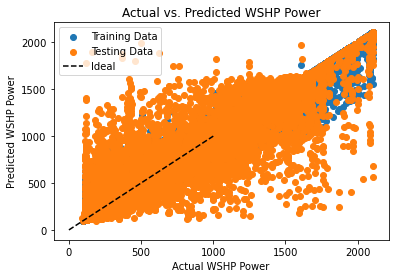

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Combine errors_avg, acc_errors_avg, and comp_spd_avg into a single DataFrame and provide column names
df = pd.DataFrame({'errors': errors_avg_all_iterations, 'acc_errors': acc_errors_avg_all_iterations, 'comp_spd': comp_spd_avg_all_iterations, 'wshp_power': wshp_power_avg_all_iterations})

# Drop rows with null values
df = df.dropna()

# Split the data into features (X) and target variable (y)
X = df[['acc_errors', 'errors']]
y = df['wshp_power']

# Seperate the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
# X_train, X_test, y_train, y_test = train_test_split(df[['errors', 'acc_errors']], df['wshp_power'], test_size=0.2, random_state=4)
# X_train, X_test, y_train, y_test = train_test_split(df[['errors', 'acc_errors']], df['comp_spd'], test_size=0.2, random_state=3)

# Create a 2nd order polynomial regression model
# model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
#                            LinearRegression(fit_intercept=True))
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model on the training data
model.fit(X_train, y_train)

Training MSE: 1821.008
Test MSE: 12885.932
Training MSE: 42.673
Test MSE: 113.516
Training R^2: 0.990
Test R^2: 0.929


/Users/aaron/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


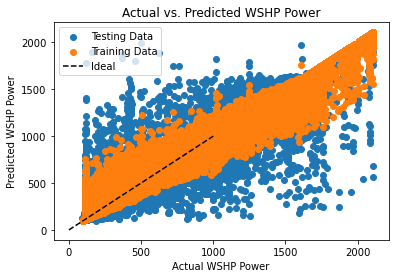

In [10]:

# Predict on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate and print the performance metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = train_mse ** 0.5
test_rmse = test_mse ** 0.5
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the performance metrics
print(f"Training MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Training MSE: {train_rmse:.3f}")
print(f"Test MSE: {test_rmse:.3f}")
print(f"Training R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}")

# Make a plot to compare predicted and actual values, one against the other
plt.figure()
plt.scatter(y_test, y_test_pred, label='Testing Data')
plt.scatter(y_train, y_train_pred, label='Training Data')
plt.plot([0, 1000], [0, 1000], 'k--', label='Ideal')
plt.xlabel('Actual WSHP Power')
plt.ylabel('Predicted WSHP Power')
plt.title('Actual vs. Predicted WSHP Power')
plt.legend()
plt.show()


### Validation (Compressor Speed or WSHP Power Prediction)

In [1]:
# Loop through the file paths
for i, file in enumerate(files):

    # Extract the series directly from the dictionary
    comp_spd_avg_temp = results[i]['comp_spd_avg']
    acc_errors_avg_temp = results[i]['acc_errors_avg']
    errors_avg_temp = results[i]['errors_avg']
    wshp_power_avg_temp = results[i]['wshp_power_avg']
    simulation_time_step_temp = results[i]['simulation_time_step']

    # Combine the series into a single DataFrame
    df = pd.DataFrame({
        'comp_spd': comp_spd_avg_temp,
        'acc_errors': acc_errors_avg_temp,
        'errors': errors_avg_temp,
        'wshp_power': wshp_power_avg_temp,
        'simulation_time_step': simulation_time_step
    })

    # Drop rows with null values
    # df = df.dropna()

    # Set the whole row to zero if any value in the row is NaN
    df = df.fillna(0)

    # Assemble the feature space
    X = df[['acc_errors', 'errors']]
    # X = df[['acc_errors']]

    # Assemble the target variable
    # y_actual = df['comp_spd']
    y_actual = df['wshp_power']

    # Predict the target variable
    y_pred = model.predict(X)

    # Calculate the RMSE between the actual and predicted compressor speed ratio
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mse ** 0.5
    print(f"RMSE: {rmse:.4f}")

    # Plot the actual and predicted compressor speed ratio
    simulation_time_step = df['simulation_time_step']
    plt.figure()
    plt.scatter(simulation_time_step, y_actual, label='Actual')
    plt.scatter(simulation_time_step, y_pred, label='Predicted')
    plt.xlabel('Simulation Time Step')
    # plt.ylabel('Compressor Speed Ratio')
    plt.ylabel('WSHP Power')
    # plt.title('Actual vs. Predicted Compressor Speed Ratio')
    plt.title('Actual vs. Predicted WSHP Power')
    plt.text(x=0.05, y=0.95, s=f'RMSE: {rmse:.3f}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.ylim(0, max(y_actual.max(), y_pred.max()))
    plt.legend()
    plt.show()




NameError: name 'files' is not defined

### Develop a Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Combine acc_errors_avg and errors_avg into a single DataFrame
df_rf = pd.DataFrame({'acc_errors_avg': acc_errors_avg_all_iterations, 'errors_avg': errors_avg_all_iterations, 'wshp_power_avg': wshp_power_avg_all_iterations})

# Drop rows with null values
df_rf = df_rf.dropna()

# Split the data into features (X) and target variable (y)
X_rf = df_rf[['acc_errors_avg', 'errors_avg']]
y_rf = df_rf['wshp_power_avg']

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=4)

# Create a Random Forest regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model on the training data
rf_model.fit(X_train_rf, y_train_rf)

# Predict on the training and testing data
y_train_pred_rf = rf_model.predict(X_train_rf)
y_test_pred_rf = rf_model.predict(X_test_rf)

# Calculate and print the performance metrics
train_mse_rf = mean_squared_error(y_train_rf, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test_rf, y_test_pred_rf)
train_rmse_rf = train_mse_rf ** 0.5
test_rmse_rf = test_mse_rf ** 0.5
train_r2_rf = r2_score(y_train_rf, y_train_pred_rf)
test_r2_rf = r2_score(y_test_rf, y_test_pred_rf)

# Print the performance metrics
print(f"Training MSE: {train_mse_rf:.3f}")
print(f"Test MSE: {test_mse_rf:.3f}")
print(f"Training RMSE: {train_rmse_rf:.3f}")
print(f"Test RMSE: {test_rmse_rf:.3f}")
print(f"Training R^2: {train_r2_rf:.3f}")
print(f"Test R^2: {test_r2_rf:.3f}")


Training MSE: 1821.008
Test MSE: 12885.932
Training RMSE: 42.673
Test RMSE: 113.516
Training R^2: 0.990
Test R^2: 0.929


### Validation for the Random Forest model

In [ ]:
# Loop through the file paths
for i, file in enumerate(files):

    # Extract the series directly from the dictionary
    comp_spd_avg_temp = results[i]['comp_spd_avg']
    acc_errors_avg_temp = results[i]['acc_errors_avg']
    errors_avg_temp = results[i]['errors_avg']
    wshp_power_avg_temp = results[i]['wshp_power_avg']

    # Combine the series into a single DataFrame
    df = pd.DataFrame({
        'comp_spd': comp_spd_avg_temp,
        'acc_errors': acc_errors_avg_temp,
        'errors': errors_avg_temp,
        'wshp_power': wshp_power_avg_temp
    })

    # Drop rows with null values
    # df = df.dropna()

    # Set the whole row to zero if any value in the row is NaN
    df = df.fillna(0)

    # Assemble the feature space
    # X = df[['errors', 'acc_errors']]
    X = df[['acc_errors']]

    # Assemble the target variable
    # y_actual = df['comp_spd']
    y_actual = df['wshp_power']

    # Predict the compressor speed ratio using the random forest model
    y_pred = rf_model.predict(X)

    # Calculate the RMSE between the actual and predicted compressor speed ratio
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mse ** 0.5
    print(f"RMSE: {rmse:.4f}")

    # Plot the actual and predicted compressor speed ratio
    plt.figure()
    plt.plot(y_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Simulation Time Step')
    # plt.ylabel('Compressor Speed Ratio')
    plt.ylabel('WSHP Power')
    # plt.title('Actual vs. Predicted Compressor Speed Ratio')
    plt.title('Actual vs. Predicted WSHP Power')
    plt.text(x=0.05, y=0.95, s=f'RMSE: {rmse:.3f}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.ylim(0, max(y_actual.max(), y_pred.max()))
    plt.legend()
    plt.show()
